In [6]:
from metpy.plots import *
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from metpy.io import *
import pandas as pd
import meteostat as mt
from datetime import datetime as dt
from dataclasses import dataclass
import metpy
import cv2
import os


@dataclass
class StationModelPlot:
    station_id: str = None
    path_to_file: str = None

    '''StationModelPlot Class takes Station_ID as String. ex:'12992'
    
    '''

    def fetch_station_data(self, start_time, end_time, obs_frequency='hourly'):
        """ start is Start time for accumulation of observations in format:YYYY:MM:DD HH:MM:SS ex_Input: '2023-03-29 07:51:00'
        end is End time range of the accumulation of data in format:YYYY:MM:DD HH:MM:SS
                                                                        -> '2023-03-29 07:51:00'
        obs_frequency is observations frequency. parameter accepts string, defaults to 'Hourly'
        Ex. 'Monthly','Daily'
        Example input:
        # a = StationModelPlot('43128') Enter a Valid Station ID to get respective station data
        # a = a.fetch_station_data('2023-03-29 07:51:00', '2023-04-29 07:51:00', 'hourly')"""
        frequency = ['hourly', 'daily', 'monthly']
        frequency_fetch = {'hourly': mt.Hourly,
                           'monthly': mt.Monthly,
                           'daily': mt.Daily

                           }
        if obs_frequency.lower() in frequency and start_time <= end_time:
            weather_data = frequency_fetch[obs_frequency](self.station_id, start_time, end_time)
            weather_data = weather_data.fetch()
            weather_data = weather_data.reset_index()
            data_parameters = list(weather_data.columns.values)
            return weather_data, data_parameters
        elif obs_frequency.lower() not in frequency:
            raise RuntimeError(f'Enter a valid observation frequency from {frequency}')
        else:
            raise RuntimeError('Start time should be less than End time')

    def custom_file_read(self):
        """This method takes the file as object or File_Path as input parameter and returns DF from
        # a= CustomData('pa1.csv')
        # a = a.custom_file_read()
        # print(a)
        """
        supported_types = ['nc', 'xml', 'txt', 'csv']
        extension_read = {'nc': xr.open_dataset,
                          'xml': pd.read_xml,
                          'txt': parse_metar_file,
                          'csv': pd.read_csv
                          }
        extension = self.path_to_file[self.path_to_file.rfind('.'):][1:]
        if extension not in supported_types:
            print(extension)
            print('txt' in supported_types)
            raise RuntimeError(f'Supported file formats are {supported_types}')
        elif extension == 'nc':
            weather_data = extension_read['nc'](self.path_to_file, engine="netcdf4")
            weather_data = weather_data.metpy.parse_cf()
            weather_data = weather_data.to_dataframe()
            weather_data = weather_data.reset_index()
            data_parameters = list(weather_data.columns.values)
        else:
            weather_data = extension_read[extension](self.path_to_file)
            if extension == 'csv':
                weather_data = weather_data.reset_index()
            # weather_data = weather_data.reset_index()
            data_parameters = list(weather_data.columns.values)
        return weather_data, data_parameters

    @staticmethod
    def parameter_validation(time_stamp_data: dict, data_columns: list):
        data_to_plot = {}
        parameter_abbreviations = {
            'station_id': ['Station_ID', 'station', 'station_id', 'STATION_ID'],
            'date_time': ['valid', 'time', 'date_time', 'time1', 'time_stamp', 'DATE_TIME'],

            'temperature': ['Temperature', 'TEMPERATURE', 'tmpt', 'air_temperature',
                            'temp', 'tmpf', 'tmpc', 'temperature', 'tavg'],
            'dew_point_temperature': ['Dew_Point_Temperature', 'DEW_POINT_TEMPERATURE', 'dwpt', 'dwpc',
                                      'dew_temp', 'dwpf', 'dew_point_temperature'],
            'wind_speed': ['WIND_SPEED', 'wspd', 'sknt', 'Wind_Speed', 'wind_speed'],
            'wind_direction': ['WIND_DIRECTION', 'Wind_Direction', 'drct', 'wdir', 'wind_direction'],
            'cloud_height': ['skyl3', 'highest_cloud_level', 'high_cloud_level',
                             'medium_cloud_level', 'low_cloud_level'],
            'pressure': ['PRESSURE', 'pres', 'mslp', 'atmospheric_pressure', 'air_pressure_at_sea_level'],
            'high_cloud': ['high_cloud_type', 'skyc3', 'high_cloud'],
            'mid_cloud': ['mid_cloud_type', 'skyc2', 'mid_cloud'],
            'low_cloud': ['low_cloud_type', 'skyc1', 'low_cloud'],
            'sky_cover': ['cloud_coverage', 'skyc1', 'sky_cover'],
            'visibility_distance': ['visibility', 'vsby', 'visibility_distance'],
            'present_weather': ['coco', 'current_weather', 'wxcodes', 'current_wx1', 'present_weather'],
            'past_weather': [],
            'pressure_tendency': [],
            'pressure_change': [],
            'pressure_difference': [],
            'precipitation': ['p01i', 'prcp', 'PRECIPITATION', 'precipitation'],
            'sky_cover_at_lowest_cloud': ['low_cloud_level', 'skyl1', 'cloud_coverage'
                                                                      'SKY_COVER_AT_LOWEST_CLOUD',
                                          'sky_cover_at_lowest_cloud']
        }
        parameters = list(parameter_abbreviations.keys())
        p= list(parameter_abbreviations.values())
        parameters_values = []
        for m in range(len(p)):
            for n in range(len(p[m])):
                parameters_values.append(p[m][n])
        for i in range(len(data_columns)):
            if data_columns[i] in parameters:
                data_to_plot[data_columns[i]] = time_stamp_data[data_columns[i]]
                if data_columns[i] == 'present_weather':
                    pass
            elif data_columns[i] not in parameters:
                if data_columns[i] in parameters_values:
                    for key, values in parameter_abbreviations.items():
                        if data_columns[i] in values:
                            index_key = key
                            data_to_plot[index_key] = time_stamp_data[data_columns[i]]
                elif data_columns[i] not in parameters_values:
                    pass
                else:
                    print(f'parameter abbreviation {data_columns[i]} is not in data, Please add abbreviation')
                    user_parameter = input(f'Select parameter from {parameters} to add a abbreviation')
                    if user_parameter in parameters:
                        user_added_abbreviation = input('Enter abbreviation for the selected parameter')
                        parameter_abbreviations[user_parameter].append(user_added_abbreviation)
                    else:
                        raise RuntimeError(f'Selected parameter is unavailable from {parameters} to add abbreviation')
            else:
                raise RuntimeError

        return data_to_plot

        # for i in range(len(b)):
        #     if b[i] in parameter_abbreviations['date_time']:
        #         if ip in a[b[i]]:
        #             c = a.loc[a[b[i]] == ip]
        #             c = c.squeeze()
        #             data_to_plot = c.to_dict()
        #         else:
        #             print(f"Entered TimeStamp doesn't exist in the {self.path}")
        #
        #     else:
        #         for key, val in parameter_abbreviations:
        #             if b[i] in parameter_abbreviations:
        #                 data_to_plot[b[i]] = a.
        #             elif b[i] not in parameter_abbreviations:
        #                 for j in val:
        # return a

    # fig, ax = plt.subplots(figsize=(10, 10))
    # sp = StationPlot(ax, 0, 0, fontsize=13, spacing=25)
    # ax.set_xlim(-8, 8)
    # ax.set_ylim(-8, 8)
    # ax.set_title('Station Model')
    # station_circle = patches.Circle((0, 0), radius=7, lw=1, edgecolor='k', facecolor='w')
    # ax.add_patch(station_circle)
    # data = {
    #     # 'temperature': None,
    #     # 'dew_point_temperature': None,
    #     # 'wind_speed': None,
    #     # 'wind_direction': None,
    #     # 'cloud_height': None,
    #     # 'pressure': None,
    #     # 'high_cloud': None,
    #     # 'mid_cloud': None,
    #     # 'low_cloud': None,
    #     # 'sky_cover': None,
    #     # 'visibility_distance': None,
    #     # 'present_weather': None,
    #     # 'past_weather': None,
    #     # 'pressure_tendency': None,
    #     # 'pressure_change': None,
    #     # 'pressure_difference': None,
    #     # 'precipitation': None,
    #     # 'sky_cover_at_lowest_cloud': None
    # }

    def plot_station_model(data: dict):
        fig, ax = plt.subplots(figsize=(10, 10))
        sp = StationPlot(ax, 0, 0, fontsize=13, spacing=25)
        ax.set_xlim(-8, 8)
        ax.set_ylim(-8, 8)
        ax.set_title('Station Model')
        station_circle = patches.Circle((0, 0), radius=7, lw=1, edgecolor='k', facecolor='w')
        ax.add_patch(station_circle)
        plot_dictionary = {
#{'station_id': 'VOHS', 'date_time': Timestamp('2023-03-23 06:00:00'),
#  'wind_direction': 280.0, 'wind_speed': 6.0, 'visibility_distance': 6000, 
# 'present_weather': '', 'low_cloud': 'NSC', 'cloud_height': '', 
# 'sky_cover_at_lowest_cloud': '', 'high_cloud': '', 'sky_cover': 0, 
# 'temperature': 30.0, 'dew_point_temperature': 10.0, 'pressure': 1014.29}

        # to add pressure_tendency symbol to the model
        'pressure_tendency' :"sp.plot_symbol((5, 0), codes=[data['pressure_tendency']],symbol_mapper=pressure_tendency,va='center', ha='center', fontsize=25)",

        # to add Sky_cover symbol to the model
        'sky_cover': "sp.plot_symbol((0, 0), codes=[data['sky_cover']], symbol_mapper=sky_cover, fontsize=25)",

        # to add pressure to the model
        'pressure': "sp.plot_text((4, 3), text=[str(data['pressure']) + ' hPa'], fontsize=13)",

        # to position wind-barb in the center of the model
        # u = -wind_speed * np.sin(np.radians(wind_direction))
        # v = -wspd_mps * math.cos(np.radians(wind_direction))
        'wind_speed': "sp.plot_barb(u=[-(data['wind_speed']) * np.sin(np.radians(data['wind_direction']))],v=[-(data['wind_speed']) * np.cos(np.radians(data['wind_direction']))], length=11)",
        # to add wind speed in knots at the end of the barb
        'wind_direction': "ax.text(1.5 * np.sin(np.radians(data['wind_direction'])),1.5 * np.cos(np.radians(data['wind_direction'])),str(data['wind_speed']) + ' kts',ha='center', va='bottom', rotation=0, fontsize=10, alpha=0.3)",

        # to add height of the cloud base
        'cloud_height': "sp.plot_text((-2, -5.5), text=[str(data['cloud_height'])], fontsize=13)",

        # to add dew_point_temperature to the model
        'dew_point_temperature': "sp.plot_text((-4, -3), text=[str(data['dew_point_temperature']) + '°C'], fontsize=13)",

        # to add high_clouds symbol to the model
        # self.sp.plot_symbol((1, 5), codes=[data['high_cloud']], symbol_mapper=high_clouds,
        #                     va='center', ha='center', fontsize=25)
        'high_cloud': "ax.text(1, 4, data['high_cloud'], fontsize=13, bbox=dict(boxstyle='round',facecolor='turquoise', alpha=0.7))",

        # to add low_clouds symbol to the model
        # sp.plot_symbol((-2, -3.5), codes=[data['low_cloud']], symbol_mapper=low_clouds,
        #                     va='center', ha='center', fontsize=25)
        'low_cloud': "ax.text(-1.5, -3, data['low_cloud'], fontsize=13, bbox=dict(boxstyle='round',facecolor='turquoise', alpha=0.2))",

        # to add mid_clouds symbol to the model
        # sp.plot_symbol((2, 3), codes=[data['mid_cloud']], symbol_mapper=mid_clouds,
        #                     va='center', ha='center', fontsize=25)
        'mid_cloud': "ax.text(0.5, 2.2, data['mid_cloud'], fontsize=13, bbox=dict(boxstyle='round',facecolor='turquoise', alpha=0.5))",

        # to add past_weather symbol to the model
        'past_weather': "sp.plot_symbol((2, -3.5), codes=data['past_weather'], symbol_mapper=current_weather,va='center', ha='center', fontsize=25)",

        # to add precipitation to the model
        'precipitation': "sp.plot_text((2, -5.5), text=[str(data['precipitation'])], fontsize=13)",

        # to add present_weather symbol to the model
        'present_weather': "sp.plot_symbol((-4, 0), codes=data['present_weather'], symbol_mapper=current_weather,va='center', ha='center', fontsize=25)",

        # to add pressure_change to the model
        'pressure_change': "sp.plot_text((3.2, 0), text=[str(data['pressure_change'])], fontsize=13)",

        # to add pressure_difference to the model
        'pressure_difference': "sp.plot_text((4, 0), text=[str(data['pressure_difference'])], fontsize=13)",

        # to add sky_cover_of the lowest cloud to the model
        'sky_cover_at_lowest_cloud': "sp.plot_text((0, -4), text=[str(data['sky_cover_at_lowest_cloud'])], fontsize=13)",

        # to add temperature to the model
        'temperature': "sp.plot_text((-4, 3), text=[str(data['temperature']) + '°C'], fontsize=13)",

        # to add visibility_distance to the model
        'visibility_distance': "sp.plot_text((-6, 0), text=[str(data['visibility_distance']) + 'meters'], fontsize=13)",

        # adds Station_ID to the model
        'Station_ID': "ax.text(4, 7, 'Station_ID: ' + data['Station_ID'], fontsize=13, weight=10)"
        }
        for key, value in data.items():
            if key in plot_dictionary:
                eval(plot_dictionary[key])
        
        name = 'Station_model.jpeg'
        path = os.path.join(os.path.dirname('output'), name)
        plt.savefig(path, dpi=100)
        
        
        
        return path + name

    # adding metpy logo at the corner
    # al = add_metpy_logo(fig=fig, x=8, y=8, zorder=5, size='small')

    # # plt.grid()
    # def main(self):
    #     dat = {'fetch data': 'Enter Station ID to fetch data',
    #            'upload data file': 'Enter Path to file'
    #            }
    #     i = 0
    #     while i == 0:
    #         a = input(f'Enter method from {list(dat.keys())}')
    #         if a.lower() == 'fetch data':
    #             st_id = input(dat[a])
    #             obj = StationModelPlot(station_id=st_id)
    #             i += 1
    #         elif a.lower() == 'upload data file':
    #             pt_to_file = input(dat[a])
    #             obj = StationModelPlot(path_to_file=pt_to_file)
    #             i += 1
    #         else:
    #             i = 0
    @staticmethod
    def get_time_stamp(time_stamp_string):
        """get_time_stamp method accepts argument as String in the format --> 'YYYY-MM-DD HH:MM:SS' """
        ts = dt.strptime(time_stamp_string, '%Y-%m-%d %H:%M:%S')
        return ts



    def __main__(self):
        obtain_method = {'fetch data': 'Enter Valid Station ID to fetch data',
                    'upload data file': 'Enter Path to file or File as object'
                    }
        parameter_abb = {
            'date_time': ['valid', 'time', 'date_time', 'time1', 'time_stamp', 'DATE_TIME'],
        }
        i = 0
        while i == 0:
            ip = input(f'Enter a method from below: \n{list(obtain_method.keys())[0]}(f) \n {list(obtain_method.keys())[1]}(u)')
            if ip.lower() == 'f':
                st_id = input(obtain_method['fetch data'])
                st = StationModelPlot(station_id=st_id)
                st_time = StationModelPlot.get_time_stamp(input("Enter End time in format: 'YYYY-MM-DD HH:MM:SS: ex. 2022-01-10 00:00:00"))
                ed_time = StationModelPlot.get_time_stamp(input("Enter End time in format: 'YYYY-MM-DD HH:MM:SS: ex. 2022-01-20 00:00:00'"))
                freq = input("Enter observation Frequency from list [Hourly, Daily, Monthly]")
                a, b = st.fetch_station_data(start_time = st_time, end_time= ed_time , obs_frequency= freq)
                i+=1
            elif ip.lower() == 'u':
                pt_to_file = input(obtain_method['upload data file'])
                st = StationModelPlot(path_to_file=pt_to_file)
                weather_data, data_parameters = st.custom_file_read()
                i+=1
            else:
                raise RuntimeWarning(f'Select method from {list(obtain_method.keys())}')
                i = 0
            while i == 1:
                
                for j in range(len(parameter_abb['date_time'])):
                    idx = parameter_abb['date_time'][j]
                    if idx in b:
                        ts_index = a[idx]
                        ts = StationModelPlot.get_time_stamp(input(f'Enter Time Stamp from {ts_index} in the format: "YYYY-MM-DD HH:MM:SS: ex. 2022-01-10 00:00:00 "'))
                        ts_data = a.loc[ts_index == ts] # a[parameter_abb['date_time'][j]]
                        ts_data = a.loc[ts_index == str(ts)] # a[parameter_abb['date_time'][j]]
                        ts_data = ts_data.squeeze()
                        ts_data = ts_data.fillna('')
                        i+=1
            
        
                    




{'station_id': 'VOHS', 'date_time': Timestamp('2023-03-20 07:00:00'), 'wind_direction': 250.0, 'wind_speed': 6.0, 'visibility_distance': 6000, 'present_weather': '', 'low_cloud': 'FEW', 'cloud_height': '', 'sky_cover_at_lowest_cloud': 2000.0, 'high_cloud': '', 'sky_cover': 2, 'temperature': 31.0, 'dew_point_temperature': 13.0, 'pressure': 1011.29}


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


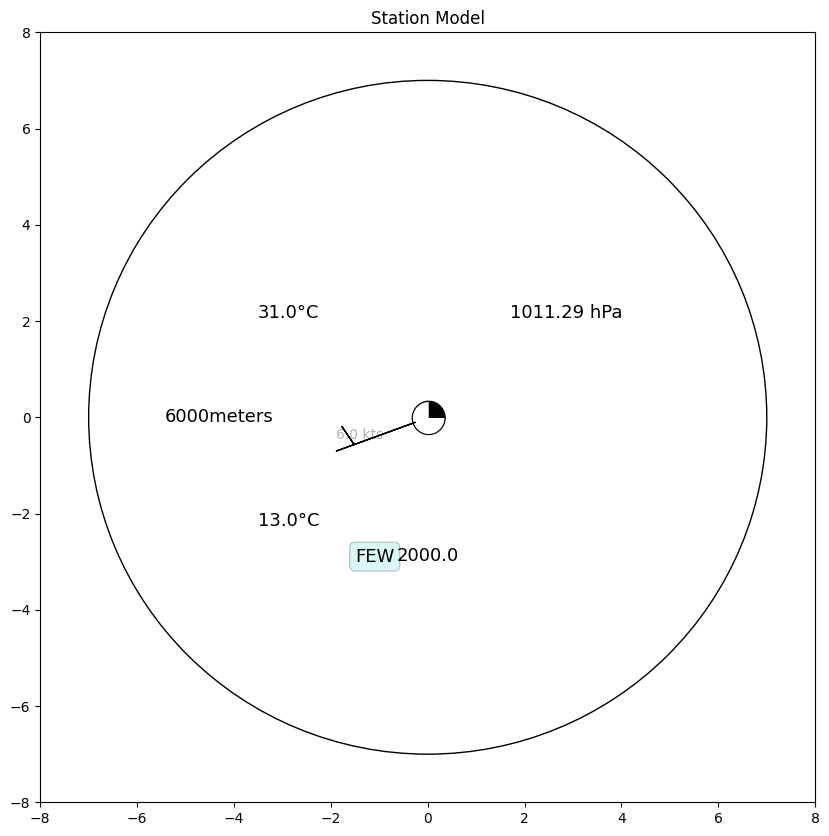

In [7]:
obtain_method = {'fetch data': 'Enter Valid Station ID to fetch data',
            'upload data file': 'Enter Path to file or File as object'
            }
i = 0

while i == 0:
    a = input(f'Enter a method from below: \n{list(obtain_method.keys())[0]}(f) \n {list(obtain_method.keys())[1]}(u)')
    if a.lower() == 'f':
        st_id = input(obtain_method['fetch data'])
        st = StationModelPlot(station_id=st_id)
        st_time = StationModelPlot.get_time_stamp(input("Enter Start time in format: 'YYYY-MM-DD HH:MM:SS: ex. 2022-01-10 00:00:00'"))
        ed_time = StationModelPlot.get_time_stamp(input("Enter End time in format: 'YYYY-MM-DD HH:MM:SS: ex. 2022-01-20 00:00:00'"))
        freq = input("Enter observation Frequency from list [Hourly, Daily, Monthly]")
        a, b = st.fetch_station_data(start_time = st_time, end_time= ed_time , obs_frequency= freq)
        i+=1
    elif a.lower() == 'u':
        pt_to_file = input(obtain_method['upload data file'])
        st = StationModelPlot(path_to_file=pt_to_file)
        a, b = st.custom_file_read()
        i+=1
    else:
        i = 0

parameter_abbreviations = {
            'station_id': ['Station_ID', 'station', 'station_id', 'STATION_ID'],
            'date_time': ['valid', 'time', 'date_time', 'time1', 'time_stamp', 'DATE_TIME'],

            'temperature': ['Temperature', 'TEMPERATURE', 'tmpt', 'air_temperature',
                            'temp', 'tmpf', 'tmpc', 'temperature', 'tavg'],
            'dew_point_temperature': ['Dew_Point_Temperature', 'DEW_POINT_TEMPERATURE', 'dwpt', 'dwpc',
                                      'dew_temp', 'dwpf', 'dew_point_temperature'],
            'wind_speed': ['WIND_SPEED', 'wspd', 'sknt', 'Wind_Speed', 'wind_speed'],
            'wind_direction': ['WIND_DIRECTION', 'Wind_Direction', 'drct', 'wdir', 'wind_direction'],
            'cloud_height': ['skyl3', 'highest_cloud_level', 'high_cloud_level',
                             'medium_cloud_level', 'low_cloud_level'],
            'pressure': ['PRESSURE', 'pres', 'mslp', 'atmospheric_pressure', 'air_pressure_at_sea_level'],
            'high_cloud': ['high_cloud_type', 'skyc3', 'high_cloud'],
            'mid_cloud': ['mid_cloud_type', 'skyc2', 'mid_cloud'],
            'low_cloud': ['low_cloud_type', 'skyc1', 'low_cloud'],
            'sky_cover': ['cloud_coverage', 'skyc1', 'sky_cover'],
            'visibility_distance': ['visibility', 'vsby', 'visibility_distance'],
            'present_weather': ['coco', 'current_weather', 'wxcodes', 'current_wx1', 'present_weather'],
            'past_weather': None,
            'pressure_tendency': None,
            'pressure_change': None,
            'pressure_difference': None,
            'precipitation': ['p01i', 'prcp', 'PRECIPITATION', 'precipitation'],
            'sky_cover_at_lowest_cloud': ['low_cloud_level', 'skyl1', 'cloud_coverage'
                                                                      'SKY_COVER_AT_LOWEST_CLOUD',
                                          'sky_cover_at_lowest_cloud']
        }
while i == 1:
    
    for j in range(len(parameter_abbreviations['date_time'])):
        idx = parameter_abbreviations['date_time'][j]
        if idx in b:
            ts_index = a[idx]
            ts = StationModelPlot.get_time_stamp(input(f'Enter Time Stamp from {ts_index} in the format: "YYYY-MM-DD HH:MM:SS: ex. 2022-01-10 00:00:00 "'))
            ts_data = a.loc[ts_index == ts] # a[parameter_abb['date_time'][j]]
            ts_data = a.loc[ts_index == str(ts)] # a[parameter_abb['date_time'][j]]
            ts_data = ts_data.squeeze()
            ts_data = ts_data.fillna('')
            i+=1

    plot_data = StationModelPlot.parameter_validation(ts_data, b)
    # try:
    print(plot_data)
    p = StationModelPlot.plot_station_model(data = plot_data)
    cv2.waitKey(10)
    img = cv2.imread(p)
    cv2.imshow('Station Model', img)
    k = cv2.waitKey(0) & 0xFF
    if k == 27:  # close on ESC key
        cv2.destroyAllWindows()
    
    # except Exception as e:
    #     continue


In [10]:
a = pd.read_csv('/home/hp/PycharmProjects/station_model/pa1.csv')
# 2023-03-20 11:00:00
eval("a.loc[a['time'] == '2018-01-07 12:00:00']")
2023-03-20 07:00:00
C:\Users\Pavan Koundinya\Desktop\metar_vij.txt

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2018-01-07 12:00:00,25.8,9.6,36.0,NaN,NaN,NaN,0.0,NaN,1010.6,NaN,NaN
